In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import json
import ipywidgets as widgets

from matplotlib.colors import ListedColormap
from os.path import join
from utils.paralell import agent_name
from utils.plotting import aligned_imshow_cbar
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
mpl.rcParams["font.size"] = 15
mpl.rcParams["figure.figsize"] = (12, 6)
mpl.rcParams["lines.linewidth"] = 2
mpl.rcParams["axes.linewidth"] = 2
mpl.rcParams["xtick.major.width"] = 2
mpl.rcParams["ytick.major.width"] = 2
mpl.rcParams["xtick.major.size"] = 5
mpl.rcParams["ytick.major.size"] = 5

In [3]:
eta_dynamic = 0
agent_pair = [-1, 0]
c_cutoff = 0 

In [4]:
d_p_dict, d_y_dict = {}, {} 
p_rich_dict, p_bank_dict = {}, {}
avg_len_dict, n_pairs_dict = {}, {}
meta_dict = {}

# Load all data
for eta_dynamic_i in [-1, 0, 1]:
    
    path_output = join("data", "v2", f"simulation_{agent_name(eta_dynamic_i)}")
    
    d_p_dict[eta_dynamic_i] = np.load(join(path_output, "d_p.npy"))
    d_y_dict[eta_dynamic_i] = np.load(join(path_output, "d_y.npy"))
    p_rich_dict[eta_dynamic_i] = np.load(join(path_output, "p_rich.npy"))
    p_bank_dict[eta_dynamic_i] = np.load(join(path_output, "p_bank.npy"))
    avg_len_dict[eta_dynamic_i] = np.load(join(path_output, "avg_len.npy"))
    n_pairs_dict[eta_dynamic_i] = np.load(join(path_output, "n_pairs.npy"))

    with open(join(path_output, "metadata.json"), "r") as f:
        meta_dict[eta_dynamic_i] = json.load(f)

In [5]:
d_p = d_p_dict[eta_dynamic]
d_y = d_y_dict[eta_dynamic]
p_rich = p_rich_dict[eta_dynamic]
p_bank = p_bank_dict[eta_dynamic]
avg_len = avg_len_dict[eta_dynamic]
n_pairs = n_pairs_dict[eta_dynamic]
meta = meta_dict[eta_dynamic]

agent_pair_idx = meta["dimensions"]["0"].index(agent_pair)

max_mag_n = meta["max_mag_n"]
c_min = meta["c_min"]
c_max = meta["c_max"]
n_c = meta["n_c"]
agents = meta["agents"]
n_trials = meta["n_trials"]

n_mag = max_mag_n + 1
dmag_range = np.array(meta["dimensions"]["3"])
c_range = np.array(meta["dimensions"]["4"])

# Adjust c_range
c_cutoff_idx = np.nonzero(c_range > c_cutoff)[0][0]
c_min = c_cutoff
d_p = d_p[:, :, :, :, c_cutoff_idx:]
d_y = d_y[:, :, :, :, c_cutoff_idx:]
p_rich = p_rich[:, :, :, :, c_cutoff_idx:]
p_bank = p_bank[:, :, :, :, c_cutoff_idx:]
avg_len = avg_len[:, :, :, :, c_cutoff_idx:]
c_range = c_range[c_cutoff_idx:]

# Get indices maximizing quality
d_p_agents = d_p[agent_pair_idx]
max_idx = d_p_agents.reshape(
    d_p_agents.shape[:2] + (np.prod(d_p_agents.shape[2:]), )
    ).argmax(2)
max_idx_dmag, max_idx_c = np.unravel_index(max_idx, d_p_agents.shape[2:])

# Marginalized matrices
d_p_opt = np.max(d_p_agents, axis=(2, 3))
opt_idx = np.unravel_index(np.argmax(d_p_opt), shape=d_p_opt.shape)

p_bank_opt = np.zeros((n_mag, n_mag))
p_rich_opt = np.zeros((n_mag, n_mag))
avg_len_opt = np.zeros((n_mag, n_mag))
n_pairs_opt = np.zeros((n_mag, n_mag))

a1, a2 = agents.index(agent_pair[0]), agents.index(agent_pair[1])
for i in range(n_mag):
    for j in range(n_mag):
        
        idx_dmag = max_idx_dmag[i, j]
        idx_c = max_idx_c[i, j]
        
        p_bank_opt[i, j] = 0.5 * (p_bank[a1, i, j, idx_dmag, idx_c] + p_bank[a2, i, j, idx_dmag, idx_c])
        p_rich_opt[i, j] = 0.5 * (p_rich[a1, i, j, idx_dmag, idx_c] + p_rich[a2, i, j, idx_dmag, idx_c])
        avg_len_opt[i, j] = 0.5 * (avg_len[a1, i, j, idx_dmag, idx_c] + avg_len[a2, i, j, idx_dmag, idx_c])
        n_pairs_opt[i, j] = n_pairs[i, j, idx_dmag]

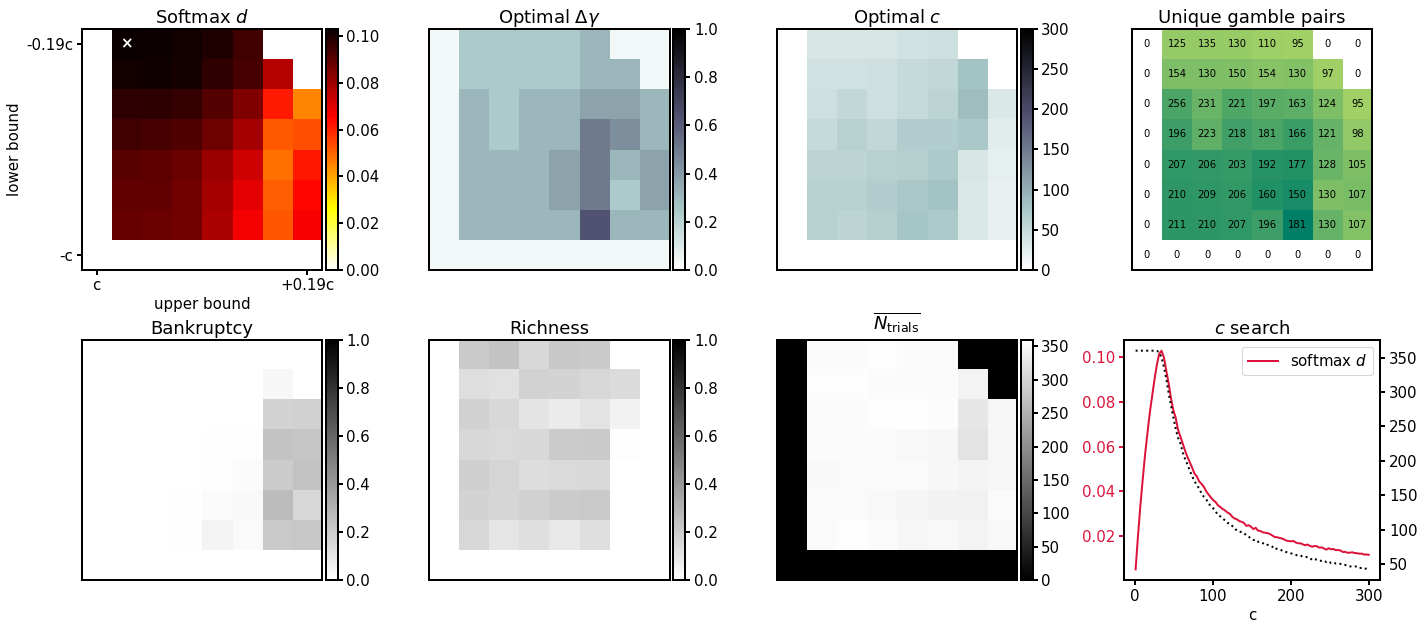

In [6]:
fig, axs = plt.subplots(figsize=(20, 9), ncols=4, nrows=2, facecolor="w")

# Disagreement 
im_dp = axs[0, 0].imshow(
    d_p_opt, 
    origin="lower", 
    cmap="hot_r",
)
axs[0, 0].set_ylabel("lower bound")
axs[0, 0].set_xlabel("upper bound")
axs[0, 0].set_title("Softmax $d$")
axs[0, 0].set_xticks([0, max_mag_n])
axs[0, 0].set_yticks([0, max_mag_n])
axs[0, 0].set_xticklabels(["c", f'{meta["dimensions"]["2"][0]:+.2f}c'])
axs[0, 0].set_yticklabels(["-c", f'{meta["dimensions"]["1"][-1]:+.2f}c'])
aligned_imshow_cbar(axs[0, 0], im_dp)
axs[0, 0].text(
    opt_idx[1], opt_idx[0], 
    s="×", c="white", va="center", ha="center",
    fontweight="bold"
)

# Optimal dmag trhreshold
im_dmag = axs[0, 1].imshow(
    dmag_range[max_idx_dmag] / 2,
    origin="lower",
    clim=[0, 1],
    cmap="bone_r"
)
axs[0, 1].set_title("Optimal $\Delta \gamma$")
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])
aligned_imshow_cbar(axs[0, 1], im_dmag)

# Optimal growth rate
im_c = axs[0, 2].imshow(
    c_range[max_idx_c], 
    origin="lower", 
    clim=[c_min, c_max], 
    cmap="bone_r"
)
axs[0, 2].set_title("Optimal $c$")
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])
aligned_imshow_cbar(axs[0, 2], im_c)

# Optimal number of unique pairs
cmap = mpl.cm.get_cmap("summer_r").copy()
cmap.set_under('white') 
axs[0, 3].imshow(
    n_pairs_opt, 
    origin="lower", 
    cmap=cmap, 
    clim=[0.5, np.max(n_pairs_opt)]
)
axs[0, 3].set_title("Unique gamble pairs")
for i in range(n_mag):
    for j in range(n_mag):
        axs[0, 3].text(i, j, int(n_pairs_opt[i, j]), 
                       ha="center", va="center", fontsize=10)


# Bankruptcy
im_bank = axs[1, 0].imshow(
    p_bank_opt, 
    origin="lower", 
    clim=[0, 1], 
    cmap="gray_r"
)
axs[1, 0].set_title("Bankruptcy")
aligned_imshow_cbar(axs[1, 0], im_bank)

# Richness
im_rich = axs[1, 1].imshow(
    p_rich_opt, 
    origin="lower", 
    clim=[0, 1], 
    cmap="gray_r"
)
axs[1, 1].set_title("Richness")
aligned_imshow_cbar(axs[1, 1], im_rich)

# Average lenght
im_len = axs[1, 2].imshow(
    avg_len_opt,
    origin="lower", 
    clim=[0, n_trials], 
    cmap="gray")
axs[1, 2].set_title(r"$\overline{N_{\mathrm{trials}}}$", pad=10)
aligned_imshow_cbar(axs[1, 2], im_len)

for i in range(2):
    for j in range(4):
        if (i, j) != (0, 0) and (i, j) != (1, 3):
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            
# Growth rate search
axs[1, 3].plot(
    c_range,
    d_p_agents[opt_idx[0], opt_idx[1], max_idx_dmag[opt_idx]],
    c="crimson",
    label="softmax $d$"
)
axs[1, 3].tick_params(axis='y', colors='crimson')
axs[1, 3].set_xlabel("c")
axs[1, 3].legend()
axs[1, 3].set_title("$c$ search")
axn = axs[1, 3].twinx()
axn.plot(
    c_range,
    avg_len[agent_pair_idx, opt_idx[0], opt_idx[1], max_idx_dmag[opt_idx]],
    c="black",
    ls=":"
)        

plt.tight_layout(w_pad=1, h_pad=0.5)

In [7]:
c_cutoff_rse = 50_000
c_cutoff_lin = 50
c_cutoff_log = 0.15

In [8]:
def plot_minmax_disagreement(c_cutoff_rse, c_cutoff_lin, c_cutoff_log, 
                             meta_dict, d_p_dict):
    """Minmax softmax disagreement over gamble dynamics.
    
    For each pair of lower and upper avg. growth rate threshold it shows max of
    minimum disagreement over gamble dynamics. It means that assuming simulation
    is true, certain level of disagreement is guaranteed across dynamics.
    
    Args:
        c_cutoff_rse (float):
            Minimal acceptable c for risk-seeking dynamic.
        c_cutoff_lin (float):
            Minimal acceptable c for additive dynamic.
        c_cutoff_log (float):
            Minimal acceptable c for multiplicative dynamic.
        meta_dict (dict):
            Metadata for all gamble dynamics.
        d_p_dict (dict):
            Softmax disagreement for all gamble dynamics.
    """
    c_range_rse = meta_dict[-1]["dimensions"]["4"]
    c_range_lin = meta_dict[0]["dimensions"]["4"]
    c_range_log = meta_dict[1]["dimensions"]["4"]

    # Find cutoff index for last dimension
    c_cutoff_rse_idx = np.nonzero(np.array(c_range_rse) > c_cutoff_rse)[0][0]
    c_cutoff_lin_idx = np.nonzero(np.array(c_range_lin) > c_cutoff_lin)[0][0]
    c_cutoff_log_idx = np.nonzero(np.array(c_range_log) > c_cutoff_log)[0][0]

    # Determine index for right agent pair for specific dynamic
    agent_pair_idx_rse = meta["dimensions"]["0"].index([-1, 0])
    agent_pair_idx_lin = meta["dimensions"]["0"].index([0, 1])
    agent_pair_idx_log = meta["dimensions"]["0"].index([0, 1])

    # Grab right array
    d_p_rse = d_p_dict[-1][agent_pair_idx_rse] 
    d_p_lin = d_p_dict[0][agent_pair_idx_lin] 
    d_p_log = d_p_dict[1][agent_pair_idx_log]

    # Exclude c based on lower-bound
    d_p_rse_cut = d_p_rse[:, :, :, c_cutoff_rse_idx:]
    d_p_lin_cut = d_p_lin[:, :, :, c_cutoff_lin_idx:]
    d_p_log_cut = d_p_log[:, :, :, c_cutoff_log_idx:]

    # Take max over allowed c and merge into single array
    d_p_stacked = np.stack((
        np.max(d_p_rse_cut, axis=-1), 
        np.max(d_p_lin_cut, axis=-1), 
        np.max(d_p_log_cut, axis=-1)
        ), axis=0)

    # Take min over condition and max over dmag threshold
    d_p_minmax = np.max(np.min(d_p_stacked, axis=0), axis=-1)

    # Grab c for argmax setups
    argmax_dmag = np.argmax(np.min(d_p_stacked, axis=0), axis=-1)
    argmax_c_rse = np.zeros((n_mag, n_mag), dtype=int)
    argmax_c_lin = np.zeros((n_mag, n_mag), dtype=int)
    argmax_c_log = np.zeros((n_mag, n_mag), dtype=int)
    for i in range(n_mag):
        for j in range(n_mag):
                argmax_c_rse[i, j] = np.argmax(d_p_rse_cut[i, j, argmax_dmag[i, j]])
                argmax_c_lin[i, j] = np.argmax(d_p_lin_cut[i, j, argmax_dmag[i, j]])
                argmax_c_log[i, j] = np.argmax(d_p_log_cut[i, j, argmax_dmag[i, j]])

    # PLOTTING
    fig, ax = plt.subplots(ncols=4, figsize=(20, 5))

    # Custom colorbars
    cmap = plt.get_cmap('bone_r', n_c)
    red = np.array([1, 0, 0, 1])

    cmap_rse = cmap(np.linspace(0, 1, n_c))
    cmap_lin = cmap(np.linspace(0, 1, n_c))
    cmap_log = cmap(np.linspace(0, 1, n_c))

    cmap_rse[:c_cutoff_rse_idx, :] = red
    cmap_lin[:c_cutoff_lin_idx, :] = red
    cmap_log[:c_cutoff_log_idx, :] = red

    cmap_rse = ListedColormap(cmap_rse)
    cmap_lin = ListedColormap(cmap_lin)
    cmap_log = ListedColormap(cmap_log)

    # Softmax disagreement
    im_minmax = ax[0].imshow(d_p_minmax, origin="lower", cmap="hot_r")
    aligned_imshow_cbar(ax[0], im_minmax)
    ax[0].set_title("Minmax over dynamics")
    ax[0].set_xticks([0, max_mag_n])
    ax[0].set_yticks([0, max_mag_n])
    ax[0].set_xticklabels(["c", f'{meta["dimensions"]["2"][0]:+.2f}c'])
    ax[0].set_yticklabels(["-c", f'{meta["dimensions"]["1"][-1]:+.2f}c'])
    ax[0].set_ylabel("lower bound")
    ax[0].set_xlabel("upper bound")

    # Optimal c for risk-seeking
    im_c_rse = ax[1].imshow(
        np.array(c_range_rse[c_cutoff_rse_idx:])[argmax_c_rse],
        origin="lower", 
        cmap=cmap_rse,
        clim=[np.min(c_range_rse), np.max(c_range_rse)]
    )
    aligned_imshow_cbar(ax[1], im_c_rse)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title("Optimal c (risk-seeking)")

    # Optimal c for additive
    im_c_lin = ax[2].imshow(
        np.array(c_range_lin[c_cutoff_lin_idx:])[argmax_c_lin],
        origin="lower", 
        cmap=cmap_lin,
        clim=[np.min(c_range_lin), np.max(c_range_lin)]
    )
    aligned_imshow_cbar(ax[2], im_c_lin)
    ax[2].set_xticks([])
    ax[2].set_yticks([])
    ax[2].set_title("Optimal c (additive)")

    # Optimal c for multiplicative
    im_c_log = ax[3].imshow(
        np.array(c_range_log[c_cutoff_log_idx:])[argmax_c_log],
        origin="lower", 
        cmap=cmap_log,
        clim=[np.min(c_range_log), np.max(c_range_log)]
    )
    aligned_imshow_cbar(ax[3], im_c_log)
    ax[3].set_xticks([])
    ax[3].set_yticks([])
    ax[3].set_title("Optimal c (multiplicative)")

    plt.tight_layout()

In [9]:
interact(
    plot_minmax_disagreement,
    c_cutoff_rse=widgets.FloatSlider(
        min=meta_dict[-1]["c_min"], max=meta_dict[-1]["c_max"], step=meta_dict[-1]["c_max"]/100), 
    c_cutoff_lin=widgets.FloatSlider(
        min=meta_dict[0]["c_min"], max=meta_dict[0]["c_max"], step=meta_dict[0]["c_max"]/100), 
    c_cutoff_log=widgets.FloatSlider(
        min=meta_dict[1]["c_min"], max=meta_dict[1]["c_max"], step=meta_dict[1]["c_max"]/100), 
    meta_dict=widgets.fixed(meta_dict), 
    d_p_dict=widgets.fixed(d_p_dict),
);

interactive(children=(FloatSlider(value=1.0, description='c_cutoff_rse', max=300000.0, min=1.0, step=3000.0), …